In [479]:
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import time

import matplotlib.pyplot as plt

import pickle

In [480]:
data = pd.read_csv('cs-training-nonull.csv')
#data = pd.read_csv('cs-training-nonull-OutliersOut.csv')
#data = pd.read_csv('cs-training-nonull-replace20only.csv')
# remove unneeded
#data = data.drop('id', axis = 1)

In [481]:
# global constants
N_ESTIMATORS = 1000
# numero di features compreso le due colonne indicatore aggiunte
N_FEATURES = 12

# nome della colonna con le label (da prevedere)
TARGET = 'SeriousDlqin2yrs'

# colonne con missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'

ind_col = [IND1, IND2]

# prese da stats sul train test, usate per inputare i missing values su COL1 e CL2
MONTHLY_INC_MEDIAN = 5400.0
N_OF_DEP_MODE = 0

In [482]:
# split in train, validation set
def split_train_test(df, ratio):
    # shuffle before split
    df = df.sample(frac = 1)
    N_REC = df.shape[0]
    N_TRAIN = int(N_REC * ratio)
    N_VALID = N_REC - N_TRAIN
    train_df = df[:N_TRAIN]
    valid_df = df[N_TRAIN:]
    
    return train_df, valid_df

In [483]:
train_df, valid_df = split_train_test(data, 0.8)

In [484]:
# metto da parte le due colonne indicatori
ind_train = train_df[ind_col].values
ind_valid = valid_df[ind_col].values

In [485]:
print(train_df[TARGET].sum()/len(train_df),valid_df[TARGET].sum()/len(valid_df))

0.06723394055608821 0.06557096387604862


In [486]:
train_df = train_df.drop(ind_col, axis = 1)
valid_df = valid_df.drop(ind_col, axis = 1)

# estrae X: matrice features ed y, labels
y_train = train_df[TARGET].values
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values

y_valid = valid_df[TARGET].values
xvalid_df = valid_df.drop(TARGET, axis = 1)
x_valid = xvalid_df.values

In [487]:
# prepara lo scaling
scaler = StandardScaler()

# calcola i parametri di scaling solo sul train set
scaler.fit(x_train)

StandardScaler()

In [488]:
# scalo tutto tranne che le due colonne indicatore
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

In [489]:
# riaggiungo gli indicatori
x_train_scaled = np.c_[x_train_scaled, ind_train]
x_valid_scaled = np.c_[x_valid_scaled, ind_valid]

In [490]:
# check
assert x_train_scaled.shape[1] == N_FEATURES
assert x_valid_scaled.shape[1] == N_FEATURES

### Train the XGBoost Classifier

In [491]:
help(xgb.XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective='binary:logistic', use_label_encoder=True, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |      use_label_encoder : bool
 |          (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new code,
 |          we recommend that you set this parameter to False.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective func

In [540]:
param_dist = {'objective':'binary:logistic', 'n_estimators':N_ESTIMATORS,
             'learning_rate':0.01, 'max_depth': 5,
             'random_state': 42, 'min_child_weight': 10.0,
             'max_delta_step': 1.8, 'colsample_bytree': 0.4,
             'subsample': 0.8, 'eta': 0.025,
             'gamma': 0.1, 'num_boost_round' : 391,'booster':'gbtree','verbosity':1}

tStart = time.time()

clf = xgb.XGBClassifier(use_label_encoder=False, **param_dist)

# valuto su train e su validation set
clf.fit(x_train_scaled, y_train,
        eval_set=[(x_train_scaled, y_train), (x_valid_scaled, y_valid)],
        eval_metric='auc', verbose=True)

tEla = time.time() - tStart

print('Elapsed time', round(tEla, 3))
print()

evals_result = clf.evals_result()

[17:45:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64728	validation_1-auc:0.64894
[1]	validation_0-auc:0.82528	validation_1-auc:0.83160
[2]	validation_0-auc:0.83163	validation_1-auc:0.83691
[3]	validation_0-auc:0.83526	validation_1-auc:0.83990
[4]	validation_0-auc:0.83159	validation_1-auc:0.83689
[5]	validation_0-auc:0.83265	validation_1-auc:0.83843
[6]	validation_0-auc:0.83818	validation_1-auc:0.84326
[7]	validation_0-auc:0.84066	validation_1-auc:0.84595
[8]	validation_0-auc:0.85352	validation_1-auc:0.85781
[9]	validation_0-auc:0.85393	validation_1-auc:0.85801
[10]	validation_0-auc:0.85746	validation_1-auc:0.86156
[11]	validation_0-auc:0.85700	validation

[142]	validation_0-auc:0.86671	validation_1-auc:0.86988
[143]	validation_0-auc:0.86667	validation_1-auc:0.86983
[144]	validation_0-auc:0.86667	validation_1-auc:0.86979
[145]	validation_0-auc:0.86673	validation_1-auc:0.86986
[146]	validation_0-auc:0.86677	validation_1-auc:0.86988
[147]	validation_0-auc:0.86679	validation_1-auc:0.86992
[148]	validation_0-auc:0.86679	validation_1-auc:0.86996
[149]	validation_0-auc:0.86682	validation_1-auc:0.86997
[150]	validation_0-auc:0.86679	validation_1-auc:0.86989
[151]	validation_0-auc:0.86679	validation_1-auc:0.86990
[152]	validation_0-auc:0.86681	validation_1-auc:0.86990
[153]	validation_0-auc:0.86685	validation_1-auc:0.86995
[154]	validation_0-auc:0.86690	validation_1-auc:0.87002
[155]	validation_0-auc:0.86697	validation_1-auc:0.87009
[156]	validation_0-auc:0.86692	validation_1-auc:0.87002
[157]	validation_0-auc:0.86692	validation_1-auc:0.87000
[158]	validation_0-auc:0.86693	validation_1-auc:0.87004
[159]	validation_0-auc:0.86694	validation_1-auc:

[289]	validation_0-auc:0.86884	validation_1-auc:0.87123
[290]	validation_0-auc:0.86884	validation_1-auc:0.87123
[291]	validation_0-auc:0.86890	validation_1-auc:0.87128
[292]	validation_0-auc:0.86893	validation_1-auc:0.87131
[293]	validation_0-auc:0.86897	validation_1-auc:0.87134
[294]	validation_0-auc:0.86897	validation_1-auc:0.87132
[295]	validation_0-auc:0.86900	validation_1-auc:0.87135
[296]	validation_0-auc:0.86899	validation_1-auc:0.87135
[297]	validation_0-auc:0.86898	validation_1-auc:0.87134
[298]	validation_0-auc:0.86896	validation_1-auc:0.87133
[299]	validation_0-auc:0.86902	validation_1-auc:0.87135
[300]	validation_0-auc:0.86906	validation_1-auc:0.87140
[301]	validation_0-auc:0.86908	validation_1-auc:0.87139
[302]	validation_0-auc:0.86913	validation_1-auc:0.87140
[303]	validation_0-auc:0.86913	validation_1-auc:0.87140
[304]	validation_0-auc:0.86915	validation_1-auc:0.87140
[305]	validation_0-auc:0.86915	validation_1-auc:0.87138
[306]	validation_0-auc:0.86915	validation_1-auc:

[436]	validation_0-auc:0.87099	validation_1-auc:0.87257
[437]	validation_0-auc:0.87100	validation_1-auc:0.87257
[438]	validation_0-auc:0.87100	validation_1-auc:0.87257
[439]	validation_0-auc:0.87101	validation_1-auc:0.87256
[440]	validation_0-auc:0.87101	validation_1-auc:0.87257
[441]	validation_0-auc:0.87102	validation_1-auc:0.87258
[442]	validation_0-auc:0.87104	validation_1-auc:0.87258
[443]	validation_0-auc:0.87106	validation_1-auc:0.87259
[444]	validation_0-auc:0.87108	validation_1-auc:0.87260
[445]	validation_0-auc:0.87108	validation_1-auc:0.87260
[446]	validation_0-auc:0.87109	validation_1-auc:0.87261
[447]	validation_0-auc:0.87110	validation_1-auc:0.87261
[448]	validation_0-auc:0.87113	validation_1-auc:0.87264
[449]	validation_0-auc:0.87115	validation_1-auc:0.87264
[450]	validation_0-auc:0.87115	validation_1-auc:0.87264
[451]	validation_0-auc:0.87116	validation_1-auc:0.87264
[452]	validation_0-auc:0.87116	validation_1-auc:0.87263
[453]	validation_0-auc:0.87117	validation_1-auc:

[583]	validation_0-auc:0.87280	validation_1-auc:0.87312
[584]	validation_0-auc:0.87281	validation_1-auc:0.87312
[585]	validation_0-auc:0.87281	validation_1-auc:0.87312
[586]	validation_0-auc:0.87282	validation_1-auc:0.87313
[587]	validation_0-auc:0.87283	validation_1-auc:0.87312
[588]	validation_0-auc:0.87284	validation_1-auc:0.87312
[589]	validation_0-auc:0.87285	validation_1-auc:0.87311
[590]	validation_0-auc:0.87286	validation_1-auc:0.87312
[591]	validation_0-auc:0.87288	validation_1-auc:0.87312
[592]	validation_0-auc:0.87291	validation_1-auc:0.87313
[593]	validation_0-auc:0.87291	validation_1-auc:0.87313
[594]	validation_0-auc:0.87292	validation_1-auc:0.87313
[595]	validation_0-auc:0.87294	validation_1-auc:0.87314
[596]	validation_0-auc:0.87294	validation_1-auc:0.87314
[597]	validation_0-auc:0.87296	validation_1-auc:0.87314
[598]	validation_0-auc:0.87297	validation_1-auc:0.87316
[599]	validation_0-auc:0.87299	validation_1-auc:0.87317
[600]	validation_0-auc:0.87301	validation_1-auc:

[730]	validation_0-auc:0.87447	validation_1-auc:0.87337
[731]	validation_0-auc:0.87449	validation_1-auc:0.87337
[732]	validation_0-auc:0.87450	validation_1-auc:0.87338
[733]	validation_0-auc:0.87451	validation_1-auc:0.87339
[734]	validation_0-auc:0.87451	validation_1-auc:0.87339
[735]	validation_0-auc:0.87451	validation_1-auc:0.87339
[736]	validation_0-auc:0.87452	validation_1-auc:0.87340
[737]	validation_0-auc:0.87453	validation_1-auc:0.87340
[738]	validation_0-auc:0.87454	validation_1-auc:0.87340
[739]	validation_0-auc:0.87456	validation_1-auc:0.87341
[740]	validation_0-auc:0.87456	validation_1-auc:0.87341
[741]	validation_0-auc:0.87457	validation_1-auc:0.87341
[742]	validation_0-auc:0.87459	validation_1-auc:0.87343
[743]	validation_0-auc:0.87460	validation_1-auc:0.87345
[744]	validation_0-auc:0.87461	validation_1-auc:0.87345
[745]	validation_0-auc:0.87461	validation_1-auc:0.87345
[746]	validation_0-auc:0.87462	validation_1-auc:0.87345
[747]	validation_0-auc:0.87464	validation_1-auc:

[877]	validation_0-auc:0.87600	validation_1-auc:0.87365
[878]	validation_0-auc:0.87601	validation_1-auc:0.87365
[879]	validation_0-auc:0.87602	validation_1-auc:0.87365
[880]	validation_0-auc:0.87604	validation_1-auc:0.87364
[881]	validation_0-auc:0.87604	validation_1-auc:0.87365
[882]	validation_0-auc:0.87605	validation_1-auc:0.87365
[883]	validation_0-auc:0.87607	validation_1-auc:0.87365
[884]	validation_0-auc:0.87607	validation_1-auc:0.87365
[885]	validation_0-auc:0.87608	validation_1-auc:0.87364
[886]	validation_0-auc:0.87608	validation_1-auc:0.87364
[887]	validation_0-auc:0.87610	validation_1-auc:0.87365
[888]	validation_0-auc:0.87611	validation_1-auc:0.87365
[889]	validation_0-auc:0.87611	validation_1-auc:0.87365
[890]	validation_0-auc:0.87612	validation_1-auc:0.87365
[891]	validation_0-auc:0.87613	validation_1-auc:0.87366
[892]	validation_0-auc:0.87614	validation_1-auc:0.87366
[893]	validation_0-auc:0.87614	validation_1-auc:0.87366
[894]	validation_0-auc:0.87615	validation_1-auc:

In [541]:
def plot_auc(train_hist, val_hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.plot(val_hist, label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

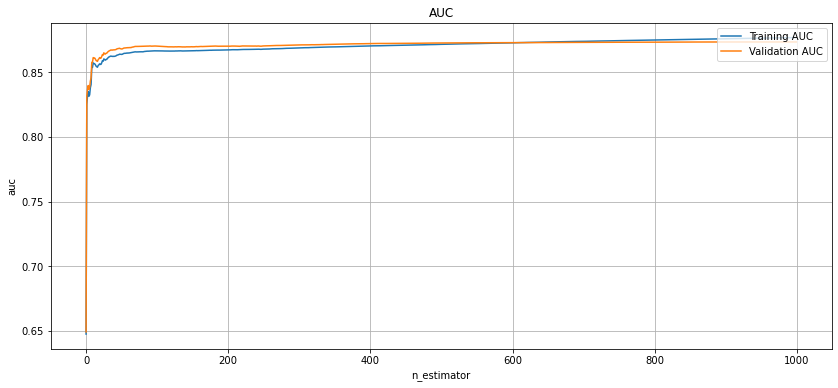

In [542]:
train_hist = evals_result['validation_0']['auc']
val_hist = evals_result['validation_1']['auc']

plot_auc(train_hist, val_hist)

In [543]:
# compute accuracy on validation set
y_pred = clf.predict(x_valid_scaled)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy on validation set: %.2f%%" % (accuracy * 100.0))

Accuracy on validation set: 93.92%


In [544]:
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
(tn, fp, fn, tp)

(27027, 263, 1513, 402)

### Prediction on the TEST set (for submission to Kaggle)

In [497]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# inpute missing values, add the two indicator columns
orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [498]:
ind_test = orig_test[ind_col].values

In [499]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [500]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [501]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [502]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test_scaled)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [503]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission21.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [212]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring-86792.pkl", "wb"))

In [213]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler-86792.pkl", "wb"))

### Online predictions

In [59]:
# reload the model
loaded_model = pickle.load(open("credit-scoring-86727.pkl", "rb"))

In [60]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler-86727.pkl", "rb"))

In [61]:
# check
type(loaded_scaler)

sklearn.preprocessing._data.StandardScaler

In [62]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [63]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [64]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)
# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [65]:
y_pred = loaded_model.predict(x_input_scaled)

In [66]:
y_pred

array([1, 1, 1])